# Iteration

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [ ]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [ ]:
# import functions from modsim

from modsim import *

To paraphrase two Georges, "All models are wrong, but some models are
more wrong than others." This chapter demonstrates the process we
use to make models less wrong.

As an example, we'll review the bike share model from the previous
chapter, consider its strengths and weaknesses, and gradually improve
it. We'll also see ways to use the model to understand the behavior of
the system and evaluate designs intended to make it work better.

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises.
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

## Iterative Modeling

The model we have so far is simple, but it is based on unrealistic
assumptions. Before you go on, take a minute to review the model from
the previous chapter. What assumptions is it based on? Make a list of
ways this model might be unrealistic; that is, what are the differences between the model and the real world?

Here are some of the differences on my list:

-   In the model, a student is equally likely to arrive during any
    one-minute period. In reality, this probability varies depending on time of day, day of the week, etc.

-   The model does not account for travel time from one bike station to another.

-   The model does not check whether a bike is available, so it's
    possible for the number of bikes to be negative (as you might have
    noticed in some of your simulations).

Some of these modeling decisions are better than others. For example,
the first assumption might be reasonable if we simulate the system for a short period of time, like one hour.

The second assumption is not very realistic, but it might not affect the results very much, depending on what we use the model for.
On the other hand, the third assumption seems more problematic.
It is relatively easy to fix, though; in this chapter, we'll fix it.

This process, starting with a simple model, identifying the most
important problems, and making gradual improvements, is called
*iterative modeling*.

For any physical system, there are many possible models, based on
different assumptions and simplifications. It often takes several
iterations to develop a model that is good enough for the intended
purpose, but no more complicated than necessary.

## More Than One State Object

Before we go on, I want to make a few changes to the code from the
previous chapter. First I'll generalize the functions we wrote so they
take a `State` object as a parameter. Then, I'll make the code more
readable by adding documentation.

Here is one of the functions from the previous chapter, `bike_to_wellesley`:

In [ ]:
def bike_to_wellesley():
    bikeshare.olin -= 1
    bikeshare.wellesley += 1

When this function is called, it modifies `bikeshare`. As long as there
is only one `State` object, that's fine, but what if there is more than
one bike share system in the world? Or what if we want to run more than
one simulation?

This function would be more flexible if it took a `State` object as a
parameter. Here's what that looks like:

In [ ]:
def bike_to_wellesley(state):
    state.olin -= 1
    state.wellesley += 1

The name of the parameter is `state`, rather than `bikeshare`, as a
reminder that the value of `state` could be any `State` object, not just the one we called `bikeshare`.

This version of `bike_to_wellesley` requires a `State` object as a
parameter, so we have to provide one when we call it:

In [ ]:
bikeshare = State(olin=10, wellesley=2)
bike_to_wellesley(bikeshare)

Again, the argument we provide gets assigned to the parameter, so this
function call has the same effect as:

```
state = bikeshare
state.olin -= 1
state.wellesley += 1
```

Now we can create as many `State` objects as we want:

In [ ]:
bikeshare1 = State(olin=10, wellesley=2)
bikeshare2 = State(olin=2, wellesley=10)

And update them independently:

In [ ]:
bike_to_wellesley(bikeshare1)
bike_to_wellesley(bikeshare2)

Changes in `bikeshare1` do not affect `bikeshare2`, and vice versa. So
we can simulate different bike share systems, or run multiple
simulations of the same system.

## Documentation

Another problem with the code we have so far is that it contains no
*documentation*.
Documentation is text we add to a program to help
other programmers read and understand it. It has no effect on the
program when it runs.

There are two kinds of documentation, *docstrings* and *comments*:

* A docstring is a string in triple quotes that appears at the beginning of a function.

* A comment is a line of text that begins with a hash symbol, `#`.

Here's a version of `bike_to_olin` with a docstring and a comment.

In [ ]:
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.

    state: bikeshare State object
    """
    # We decrease one state variable and increase the
    # other so the total number of bikes is unchanged.
    state.wellesley -= 1
    state.olin += 1

Docstrings follow a conventional format:

-   The first line is a single sentence that describes what the function does.

-   The following lines explain what the parameters are.

A function's docstring should include the information someone needs to
know to *use* the function; it should not include details about how the function works.

Comments provide details about how the function works, especially if there is something that would not be obvious to someone reading the program.

## Negative Bikes

The changes we've made so far improve the quality of the code, but we
haven't done anything to improve the quality of the model. Let's do that now.

Currently the simulation does not check whether a bike is available when a customer arrives, so the number of bikes at a location can be
negative. That's not very realistic.

Here's a version of `bike_to_olin` that fixes the problem:

In [ ]:
def bike_to_olin(state):
    if state.wellesley == 0:
        return
    state.wellesley -= 1
    state.olin += 1

The first line checks whether the number of bikes at Wellesley is zero. If so, it uses a *return statement*, which causes the function to end immediately, without running the rest of the statements. So if there are no bikes at Wellesley, we return from `bike_to_olin` without changing the state.

We can test it by initializing the state with no bikes at Wellesley and calling `bike_to_olin`.

In [ ]:
bikeshare = State(olin=12, wellesley=0)
bike_to_olin(bikeshare)

The state of the system should be unchanged.

In [ ]:
show(bikeshare)

,state
olin,12
wellesley,0


No more negative bikes (at least at Wellesley).

## Comparison Operators

The updated version of `bike_to_olin` uses the equals operator, `==`, which compares two values and returns `True` if they are equal, and `False` otherwise.

It is easy to confuse the equals operator with the assignment operator, `=`, which assigns a value to a variable. For example, the following statement creates a variable, `x`, if it doesn't already exist, and gives it the value `5`.

In [ ]:
x = 5

On the other hand, the following statement checks whether `x` is `5` and
returns `True` or `False`. It does not create `x` or change its value.

In [ ]:
x == 5

True

You can use the equals operator in an `if` statement, like this:

In [ ]:
if x == 5:
    print('yes, x is 5')

yes, x is 5


If you make a mistake and use `=` in an `if` statement, like this:

```
if x = 5:
    print('yes, x is 5')
```

That's a *syntax error*, which means that the structure of the program is invalid. Python will print an error message and the program won't run.

The equals operator is one of Python's *comparison operators*; the complete list is in the following table.

| Operation             | Symbol |
|-----------------------|--------|
| Less than             | `<`    |
| Greater than          | `>`    |
| Less than or equal    | `<=`   |
| Greater than or equal | `>=`   |
| Equal                 | `==`   |
| Not equal             | `!=`   |

## Metrics

Getting back to the bike share system, at this point we have the ability to simulate the behavior of the system. Since the arrival of customers is random, the state of the system is different each time we run a
simulation. Models like this are called random or *stochastic*; models
that do the same thing every time they run are *deterministic*.

Suppose we want to use our model to predict how well the bike share
system will work, or to design a system that works better. First, we
have to decide what we mean by "how well" and "better".

From the customer's point of view, we might like to know the probability of finding an available bike. From the system-owner's point of view, we might want to minimize the number of customers who don't get a bike when they want one, or maximize the number of bikes in use. Statistics like these that quantify how well the system works are called *metrics*.

As an example, let's measure the number of unhappy customers.
Here's a version of `bike_to_olin` that keeps track of the number of
customers who arrive at a station with no bikes:

In [ ]:
def bike_to_olin(state):
    if state.wellesley == 0:
        state.wellesley_empty += 1
        return
    state.wellesley -= 1
    state.olin += 1

If a customer arrives at the Wellesley station and finds no bike
available, `bike_to_olin` updates `wellesley_empty`, which counts the
number of unhappy customers.

This function only works if we initialize `wellesley_empty` when we
create the `State` object, like this:

In [ ]:
bikeshare = State(olin=12, wellesley=0,
                  wellesley_empty=0)

We can test it by calling `bike_to_olin`:

In [ ]:
bike_to_olin(bikeshare)

After this update, there should be 12 bikes at Olin, no bikes at Wellesley, and one unhappy customer.

In [ ]:
show(bikeshare)

,state
olin,12
wellesley,0
wellesley_empty,1


Looks good!

## Summary

In this chapter, we wrote several versions of `bike_to_olin`:

* We added a parameter, `state`, so we can work with more than one `State` object.

* We added a docstring that explains how to use the function and a comment that explains how it works.

* We used a conditional operator, `==`, to check whether a bike is available, in order to avoid negative bikes.

* We added a state variable, `wellesley_empty`, to count the number of unhappy customers, which is a metric we'll use to quantify how well the system works.

In the exercises, you'll update `bike_to_wellesley` the same way and test it by running a simulation.

## Exercises

Here's the code we have so far, with docstrings, all in one place.

In [ ]:
def run_simulation(state, p1, p2, num_steps):
    """Simulate the given number of time steps.

    state: State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    num_steps: number of time steps
    """
    results = TimeSeries()
    results[0] = state.olin

    for i in range(num_steps):
        step(state, p1, p2)
        results[i+1] = state.olin

    results.plot(label='Olin')
    decorate(title='Olin-Wellesley Bikeshare',
             xlabel='Time step (min)',
             ylabel='Number of bikes')

In [ ]:
def step(state, p1, p2):
    """Simulate one time step.

    state: bikeshare State object
    p1: probability of an Olin->Wellesley ride
    p2: probability of a Wellesley->Olin ride
    """
    if flip(p1):
        bike_to_wellesley(state)

    if flip(p2):
        bike_to_olin(state)

In [ ]:
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.

    state: bikeshare State object
    """
    if state.wellesley == 0:
        state.wellesley_empty += 1
        return
    state.wellesley -= 1
    state.olin += 1

In [ ]:
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.

    state: bikeshare State object
    """
    state.olin -= 1
    state.wellesley += 1

### Exercise 1

 Modify `bike_to_wellesley` so it checks whether a bike is available at Olin.  If not, it should add `1` to `olin_empty`.

To test it, create a `State` that initializes `olin` and `olin_empty` to `0`, run `bike_to_wellesley`, and check the result.

In [ ]:
# Solution goes here
def bike_to_wellesley(state):
    """Move one bike from Wellesley to Olin.

    state: bikeshare State object
    """
    if state.olin == 0:
        state.olin_empty += 1
        return
    state.olin -= 1
    state.wellesley += 1


In [ ]:
# Solution goes here
bikeshare2 = State(olin = 0, wellesley = 2, olin_empty = 0)
bike_to_wellesley(bikeshare2)

In [ ]:
# Solution goes here
print(bikeshare2)

olin          0
wellesley     2
olin_empty    1
Name: state, dtype: int64


### Exercise 2

 Now run the simulation with parameters `p1=0.3`, `p2=0.2`, and `num_steps=60`, and confirm that the number of bikes is never negative.

Start with this initial state:

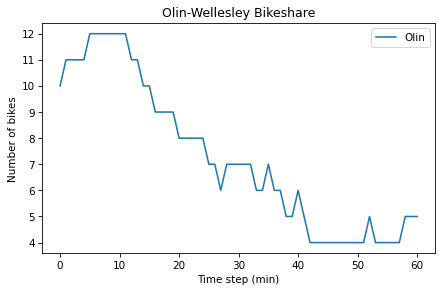

In [ ]:
bikeshare = State(olin=10, wellesley=2,
                  olin_empty=0, wellesley_empty=0)

np.random.seed(1994)
run_simulation(bikeshare, 0.3, 0.2, 60)

In [ ]:
# Solution goes here

"""
The number of bikes at Olin never goes negative, but it also never even 0.
This means that the number of bikes at Olin never reaches 0, so olin_empty should be 0.
"""

print(bikeshare.olin_empty)

# olin_empty = 0, as desired

"""
The number of bikes at Olin briefly reaches 12,
so it is possible that wellesley_empty is nonzero.
"""

print(bikeshare.wellesley_empty)

"""
As expected, while all 12 bikes were in Olin,
one person came looking for a bike at Wellesley.
"""

0
1


'\nAs expected, while all 12 bikes were in Olin,\none person came looking for a bike at Wellesley.\n'